# BIBLIOTHEQUES

In [1]:
import os
import os.path
os.chdir("C:/Users/maell/Fake_News_Project")

import urllib.request
import zipfile

import pandas as pd
import numpy as np
import community

from scipy import *

from itertools import combinations
from collections import Counter

import matplotlib.pyplot as plt

import networkx as nx

%matplotlib inline

# FUNCTIONS

In [2]:
def controversial_website_in_graph(fake_news_sources, date, register=False): #REVOIR ICI ARGUMENT OPTIONNEL !!!
    file='graph_'+date+'.gexf'
    G=nx.read_gexf(file)
    for node in list(G.nodes):
        if node in fake_news_sources:
                G.node[node]['Controversial Website']=fake_news_sources_df.loc[node].type
        else:       
            G.node[node]['Controversial Website']=None
    if register==True:
        file_name='graph_'+day+'_controversial_website.gexf'
        nx.write_gexf(G,file_name)
    return(G)

################################################################################################################################

def label_controversial_website(G): #OK
    fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
    fake_news_sources_df.set_index('url',inplace=True)
    fake_news_sources=list(fake_news_sources_df.index.unique())
    for node in list(G.nodes):
        if node in fake_news_sources:
                G.node[node]['Controversial Website']=fake_news_sources_df.loc[node].type
        else:       
            G.node[node]['Controversial Website']=None
    return (G)

################################################################################################################################

def label_propagation_controversial_website_total(G,critere,params,show_results=None,show_working=None,nb_retry=100):

    #Récupération des paramètres 
    [confidence_type, controversial_type, fake_news_sources_df]=params
    
    #Create labels of nodes
    G=label_controversial_website(G);
    
    #Create list know nodes and other nodes
    list_known_nodes=[]
    list_other_nodes=[]
    for node in list(G.nodes):
        if node in fake_news_sources:
            list_known_nodes.append(node)
        else:
            list_other_nodes.append(node)
    list_known_nodes=list(set(list_known_nodes))
    list_other_nodes=list(set(list_other_nodes))
    
    #Create train and test set
    total_set=list_known_nodes
    test_set=[]
    train_set=[]
    for i in range (0,len(total_set)):
        nb=np.random.randint(3)
        if nb==2:
            test_set.append(total_set[i])
            G.node[total_set[i]]['Controversial Website']=None #delete referency
        else:
            train_set.append(total_set[i])
            
    # Classification
    compteur=0;
    compteur_retry=0;

    test_set_qui_se_vide=test_set.copy()
    test_set_qui_se_vide += list_other_nodes
    
    while test_set_qui_se_vide!=[]:
        #On tire un point au hasard
        number_nodes=len(test_set_qui_se_vide)
        if number_nodes>1:
            node=test_set_qui_se_vide[random.randint(0,number_nodes-1)]
        else:
            node=test_set_qui_se_vide[0]
        
        #On regarde ses voisins
        list_node_neighbor=list(G.neighbors(node))
        
        controversial_weight=0;
        confidence_weight=0;
        for neighboor in list_node_neighbor:
            value=G.node[neighboor]['Controversial Website']
            if value in confidence_type:
                confidence_weight+=G.edges[node,neighboor]['weight']
            elif value in controversial_type:
                controversial_weight+=G.edges[node,neighboor]['weight']
            
        if confidence_weight==controversial_weight :
            compteur_retry+=1
            if show_working==True:
                print('Retry',compteur_retry)
            if compteur_retry>nb_retry:
                if show_working==True:
                    print('END')
                break
        else:
            if confidence_weight>critere*controversial_weight:
                G.node[node]['Controversial Website']='confidence'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
            elif controversial_weight>critere*confidence_weight:
                G.node[node]['Controversial Website']='controversial'
                test_set_qui_se_vide.remove(node)
                compteur=compteur+1
                if show_working==True:
                    print('Classified :',compteur)
                compteur_retry=0
                
    # Evaluation
    confidence_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(confidence_type)].index)
    controversial_website=list(fake_news_sources_df.loc[fake_news_sources_df['type'].isin(controversial_type)].index)

    well_classified_confidence=0;
    well_classified_controversial=0;
    bad_classified=0;
    for node in test_set:
        if G.nodes[node]['Controversial Website'] in confidence_type and node in confidence_website:
            well_classified_confidence+=1
        elif G.nodes[node]['Controversial Website'] in controversial_type and node in controversial_website :
            well_classified_controversial+=1
        elif G.nodes[node]['label'] in test_set_qui_se_vide :
            test=0
        else:
            bad_classified+=1

    well_classified=well_classified_confidence+well_classified_controversial
    not_classified=len(test_set)-well_classified-bad_classified
    if show_results==True:
        print('Number of nodes to classified :',len(test_set))
        print('Number of nodes not classified :',not_classified,'-',100*(not_classified)/len(test_set),'%')
        print('Number of well classified nodes :',well_classified,'-',100*well_classified/len(test_set),'%')
        print('Number of bad classifed nodes :',bad_classified,'-',100*bad_classified/len(test_set),'%')
        
    # DF resultat
    df_resultat=pd.DataFrame(columns=['Reference','Found','WebsiteURL'])
    df_resultat.set_index('WebsiteURL',inplace=True)
    for node in test_set:
        df_resultat=df_resultat.append({'WebsiteURL':node, 'Reference':fake_news_sources_df.loc[node].type, 'Found':G.nodes[node]['Controversial Website']}, ignore_index=True)
        
    
    return(G, df_resultat, len(test_set),not_classified,well_classified_controversial,well_classified_confidence,bad_classified)

# USEFUL VARIABLES

In [3]:
confidence_type=['political','reliable','confidence']
controversial_type=['bias','fake','conspiracy','unknown','satire','hate','clickBait','clickbait','junksci','rumor',
                    'unreliable','state','controversial']

fake_news_sources_df=pd.read_csv('Classification_Website_False.csv',sep = ';',decimal = '.')
fake_news_sources_df.set_index('url',inplace=True)
fake_news_sources=list(fake_news_sources_df.index.unique())

params=[confidence_type, controversial_type, fake_news_sources_df]

# TYPE PROPAGATION : CHOICE OF CRITERIA

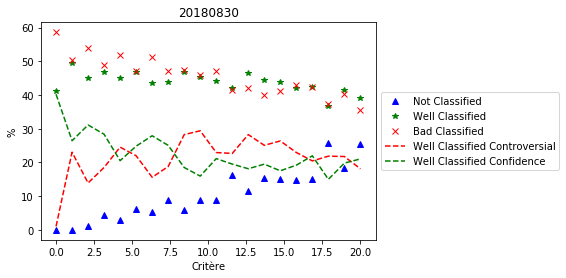

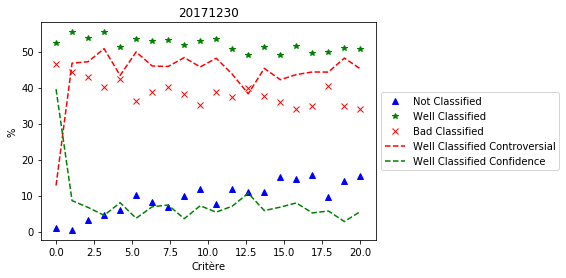

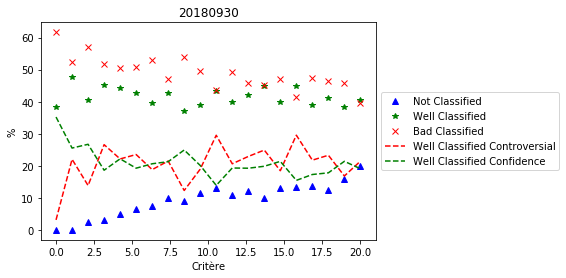

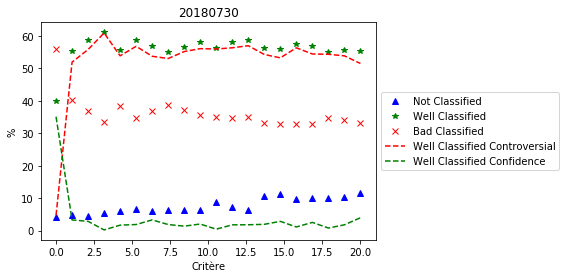

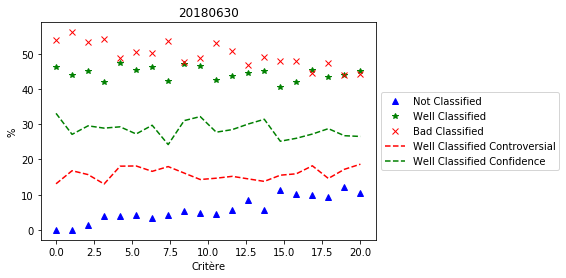

In [4]:
################################################  PARAMETERS  ###############################################################

date_liste=['20180830','20171230','20180930','20180730','20180630'] #list of days to study
f= 40 #nb of folds
list_critere= np.linspace(0, 20, num=20) #list of criteria to test
nb_retry=50 #Not mandatory (100 if not given)

###############################################  ALGORITHME  ################################################################

for date in date_liste:
    list_not_classified=[];
    list_well_classified=[];
    list_well_classified_controversial=[]
    list_well_classified_confidence=[]
    list_bad_classified=[];

    file='graph_'+date+'.gexf'
    G=nx.read_gexf(file)

    for critere in list_critere:
        mean_not_classified=0
        mean_well_classified=0
        mean_bad_classified=0
        mean_well_classified_controversial=0;
        mean_well_classified_confidence=0;

        for i in range (0,f):
            #print('f=',i,'et critere=',critere)
            [G_total, df_res, to_classify, not_classified, well_classified_controversial,well_classified_confidence, bad_classified]=label_propagation_controversial_website_total(G,critere,params,nb_retry=nb_retry)
            
            mean_not_classified+=not_classified/to_classify
            mean_well_classified_controversial+=well_classified_controversial/to_classify
            mean_well_classified_confidence+=well_classified_confidence/to_classify
            mean_well_classified+=(well_classified_confidence+well_classified_controversial)/to_classify
            mean_bad_classified+=bad_classified/to_classify

        list_not_classified.append(100*mean_not_classified/f)
        list_well_classified.append(100*mean_well_classified/f)
        list_well_classified_controversial.append(100*mean_well_classified_controversial/f)
        list_well_classified_confidence.append(100*mean_well_classified_confidence/f)
        list_bad_classified.append(100*mean_bad_classified/f)

    # plot graph
    plt.figure()
    
    plt.plot(list_critere, list_not_classified,'b^',label='Not Classified')
    plt.plot(list_critere, list_well_classified,'g*',label='Well Classified')
    plt.plot(list_critere, list_bad_classified,'rx',label='Bad Classified')
    plt.xlabel('Critère')
    plt.ylabel('%')
    
    plt.plot(list_critere,list_well_classified_controversial,'r--',label="Well Classified Controversial")
    plt.plot(list_critere,list_well_classified_confidence,'g--',label="Well Classified Confidence")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(date)


## Conclusion
- The higher criteria, the higher number of not classified nodes,
- Need to have a high number of fold because very fluctuent (big graph with a lot of nodes)

# TYPE PROPAGATION : STUDY OF THE BEST CRITERIA
To be done